### Batch effect correction in multi time point dataset using BBKNN and ComBat
author: Juliska E Boer

date: 03 Nov 2020

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import scvelo as scv
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.sparse import csr_matrix

#settings
sc.settings.verbosity = 3
sc.logging.print_versions()
scv.logging.print_versions()
sc.settings.figdir = "../../figures/embryo_Hb/"
scv.settings.figdir = "../../figures/embryo_Hb/"
sc.settings.set_figure_params(dpi=80)

C:\Users\Juliska\Anaconda3\envs\UMCU\lib\site-packages\anndata\_core\anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.6 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.1 scikit-learn==0.22.1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1
scvelo==0.1.25  scanpy==1.4.6  anndata==0.7.1  loompy==2.0.17  numpy==1.18.1  scipy==1.4.1  matplotlib==3.2.1  sklearn==0.22.1  pandas==1.0.1  

In [2]:
c_cont_red = mpl.colors.LinearSegmentedColormap.from_list('custom_red', 
                                             [(0, 'silver'),
                                              (0.1, (1, 0.82, 0.82)),
                                              (0.2, (1, 0.67, 0.67)),
                                              (0.3, (1, 0.58, 0.58)),
                                              (0.4, (1, 0.48, 0.48)),
                                              (0.5, (1, 0.38, 0.38)),
                                              (0.6, (1, 0.29, 0.29)),
                                              (0.7, (1, 0.22, 0.22)),
                                              (0.8, (1, 0.15, 0.15)),
                                              (0.9, (0.67, 0.09, 0.09)),
                                              (1, (0.54, 0, 0))], N=128)
c_cont_green = mpl.colors.LinearSegmentedColormap.from_list('custom_green', 
                                             [(0, 'silver'),
                                              (0.1, (0.50, 0.93, 0.60)),
                                              (0.2, (0.4, 0.89, 0.5)),
                                              (0.3, (0.3, 0.81, 0.4)),
                                              (0.4, (0.2, 0.73, 0.3)),
                                              (0.5, (0.1, 0.69, 0.2)),
                                              (0.6, (0, 0.62, 0.185)),
                                              (0.7, (0, 0.55, 0.16)),
                                              (0.8, (0, 0.47, 0.15)),
                                              (0.9, (0, 0.36, 0.11)),
                                              (1, (0, 0.29, 0.06))], N=128)
c_cont_blue = mpl.colors.LinearSegmentedColormap.from_list('custom_blue', 
                                             [(0, 'silver'),
                                              (0.1, (0.67, 0.77, 1)),
                                              (0.2, (0.58, 0.68, 1)),
                                              (0.3, (0.48, 0.58, 1)),
                                              (0.4, (0.38, 0.48, 1)),
                                              (0.5, (0.29, 0.39, 1)),
                                              (0.6, (0.22, 0.32, 1)),
                                              (0.7, (0.15, 0.25, 1)),
                                              (0.8, (0.09, 0.19, 1)),
                                              (0.9, (0, 0.1, 0.75)),
                                              (1, (0, 0.1, 0.5))], N=128)

Read in filtered dataset

In [3]:
adata = sc.read_h5ad('../../data/output/embryo_Hb/Mar2020_embryo_Hb_filtered_Pou4f1_only.h5ad')

Normalize and log-transform

In [4]:
sc.pp.normalize_total(adata, key_added='n_counts_norm',layers = 'all')

normalizing counts per cell
    finished (0:00:00)


In [5]:
adata.raw = adata.copy()
sc.pp.log1p(adata)

Select and plot highly variable genes

extracting highly variable genes
    finished (0:00:09)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


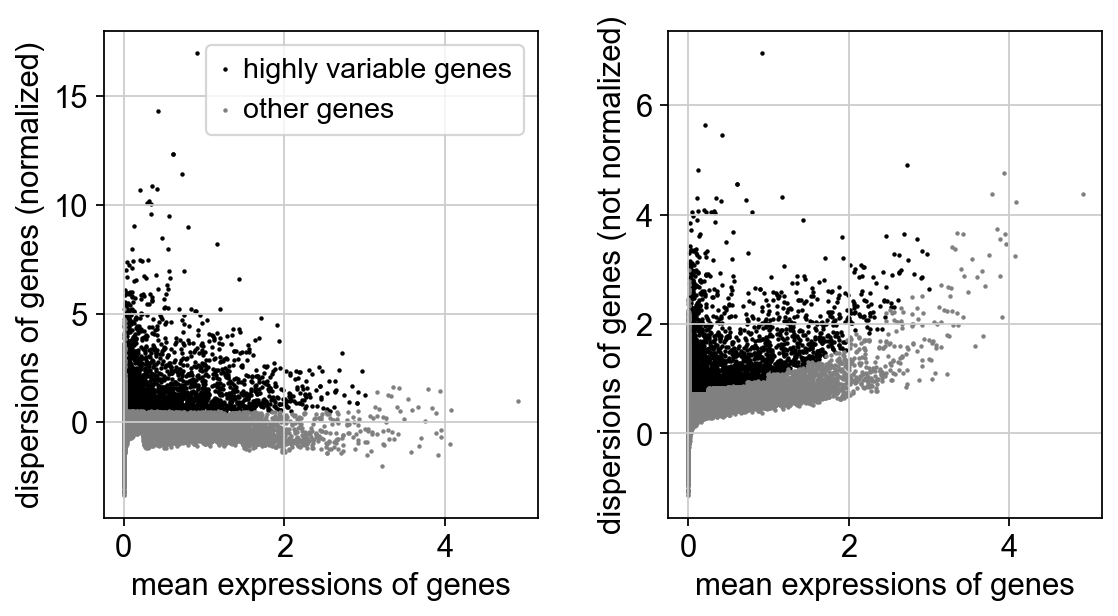

In [6]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
sc.pl.highly_variable_genes(adata)

Filter on highly variable genes

In [7]:
adata = adata[:, adata.var['highly_variable']]
adata

View of AnnData object with n_obs × n_vars = 2773 × 3783 
    obs: 'n_genes', 'plate', 'platebatch', 'stage', 'well_no', 'ERCC_genes', 'n_total_counts', 'percent_mito', 'n_counts', 'percent_ribo', 'percent_protein_coding', 'percent_lincRNA', 'sum_lincRNA', 'percent_antisense', 'sum_antisense', 'percent_miRNA', 'sum_miRNA', 'percent_bidirectional_promoter_lncRNA', 'sum_bidirectional_promoter_lncRNA', 'percent_snoRNA', 'n_counts_norm'
    var: 'ENS_names', 'geneid', 'feature', 'chr', 'fullname', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'plate_colors', 'log1p'
    layers: 'spliced', 'unspliced'

Regress out counts and scale data

In [8]:
sc.pp.regress_out(adata, 'n_counts')
sc.pp.scale(adata, max_value=10)

regressing out n_counts
    finished (0:00:34)


### Raw

In [9]:
adata_raw = adata.copy()

Perform PCA

In [10]:
sc.tl.pca(adata_raw, svd_solver='arpack')

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)


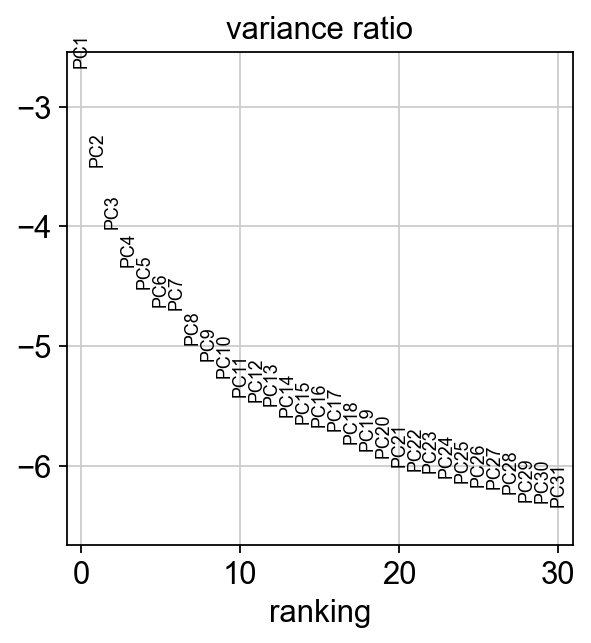

In [11]:
sc.pl.pca_variance_ratio(adata_raw, log=True)

Calculate nearest neighborhood graph and t-SNE embeddings

In [12]:
sc.pp.neighbors(adata_raw, n_neighbors=10, n_pcs=40) 

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)


In [13]:
sc.tl.tsne(adata_raw) 

computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:26)


Perform louvain clustering

In [14]:
sc.tl.louvain(adata_raw)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 17 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


t-SNE plots colored by sampling time point and Louvain clustering

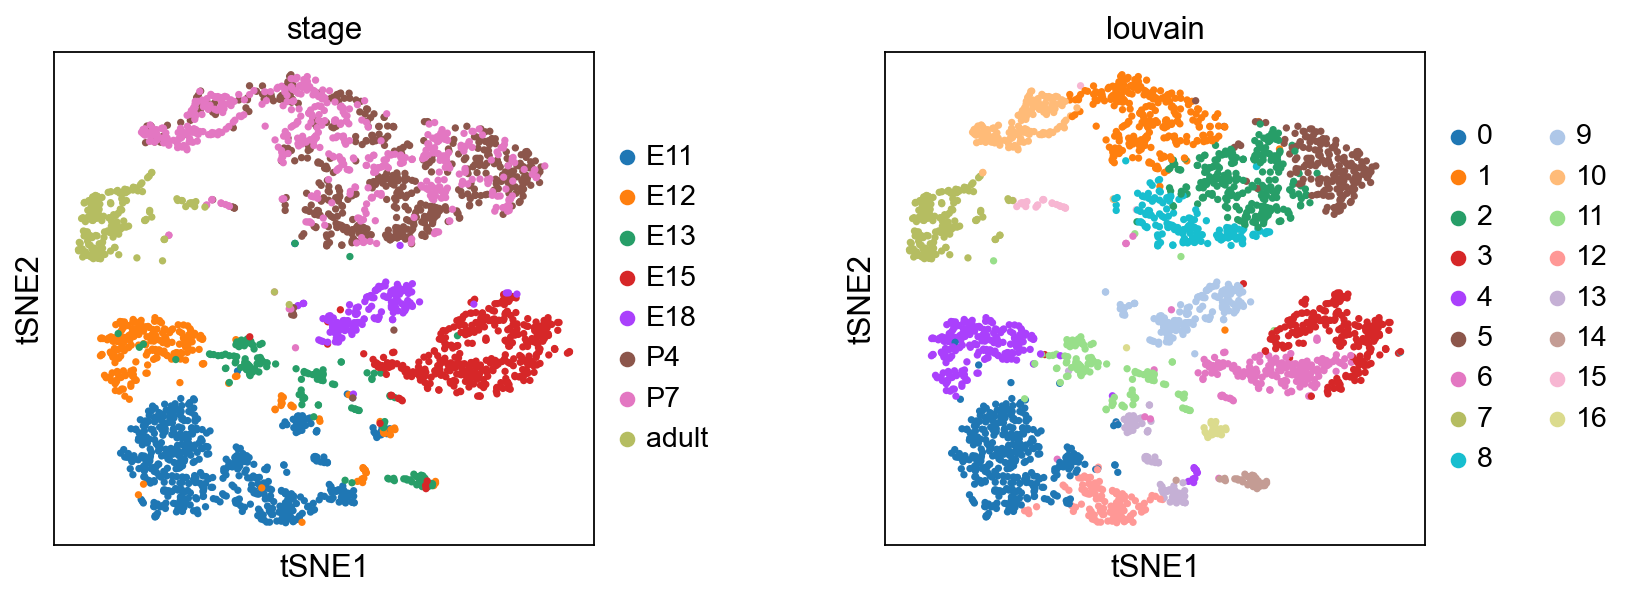

In [15]:
sc.pl.tsne(adata_raw, color=['stage', 'louvain'], wspace=0.4, save="_batchcorr_rawscanpy.pdf")

Export meta data and t-SNE coordinates for ARI and LISI validation

In [16]:
adata_raw.obs.to_csv("../../data/output/embryo_Hb/BatchTest_raw_metadata.csv")
tsne_raw = pd.DataFrame(adata_raw.obsm["X_tsne"])
tsne_raw.index = adata_raw.obs.index
tsne_raw.to_csv("../../data/output/embryo_Hb/BatchTest_raw_tsne.csv")

### Batch effect correction

#### BBKNN

In [17]:
adata_b = adata.copy()

Perform PCA and calculate nearest neighborhood graph

In [18]:
sc.tl.pca(adata_b, svd_solver='arpack')
sc.pp.neighbors(adata_b, n_neighbors=10, n_pcs=40) 

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:01)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


Perform batch effect correction using BBKNN

In [19]:
sc.external.pp.bbknn(adata_b, batch_key="stage")

computing batch balanced neighbors
	finished: added to `.uns['neighbors']`
	'distances', weighted adjacency matrix
	'connectivities', weighted adjacency matrix (0:00:04)


Calculate UMAP coordinates and perform Louvain clustering

In [20]:
sc.tl.umap(adata_b)
sc.tl.louvain(adata_b)

computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 6 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


UMAP plots colored by sampling time point and Louvain clustering

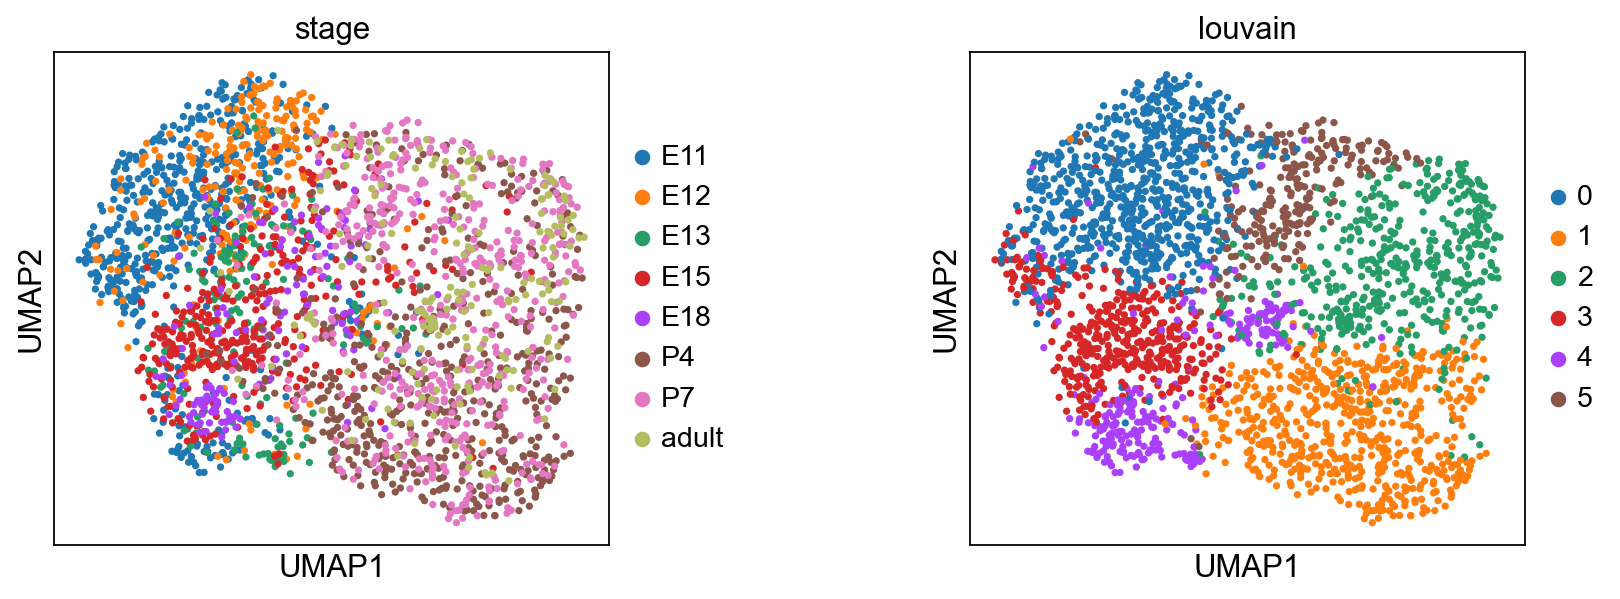

In [21]:
sc.pl.umap(adata_b, color=['stage', 'louvain'], wspace=0.5, save="_batchcorr_bbknn.pdf")

Export meta data and UMAP coordinates for ARI and LISI validation

In [22]:
adata_b.obs.to_csv("../../data/output/embryo_Hb/BatchTest_BBKNN_metadata.csv")
umap_b = pd.DataFrame(adata_b.obsm["X_umap"])
umap_b.index = adata_b.obs.index
umap_b.to_csv("../../data/output/embryo_Hb/BatchTest_BBKNN_umap.csv")

#### ComBat

In [23]:
adata_c = adata.copy()

Perform batch effect correction using ComBat

In [24]:
sc.pp.combat(adata_c, key='stage', covariates=None, inplace=True)

Standardizing Data across genes.

Found 8 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments

Adjusting data



Perform PCA, calculate nearest neighborhood graph and t-SNE coordinates. Perform Louvain clustering

In [25]:
sc.tl.pca(adata_c, svd_solver='arpack')
sc.pp.neighbors(adata_c, n_neighbors=10, n_pcs=40) 
sc.tl.tsne(adata_c)
sc.tl.louvain(adata_c)

    on highly variable genes
computing PCA with n_comps = 50
    finished (0:00:02)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing tSNE
    using 'X_pca' with n_pcs = 50
    using the 'MulticoreTSNE' package by Ulyanov (2017)
    finished: added
    'X_tsne', tSNE coordinates (adata.obsm) (0:00:21)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 14 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


t-SNE plots colored by sampling time point and Louvain clustering

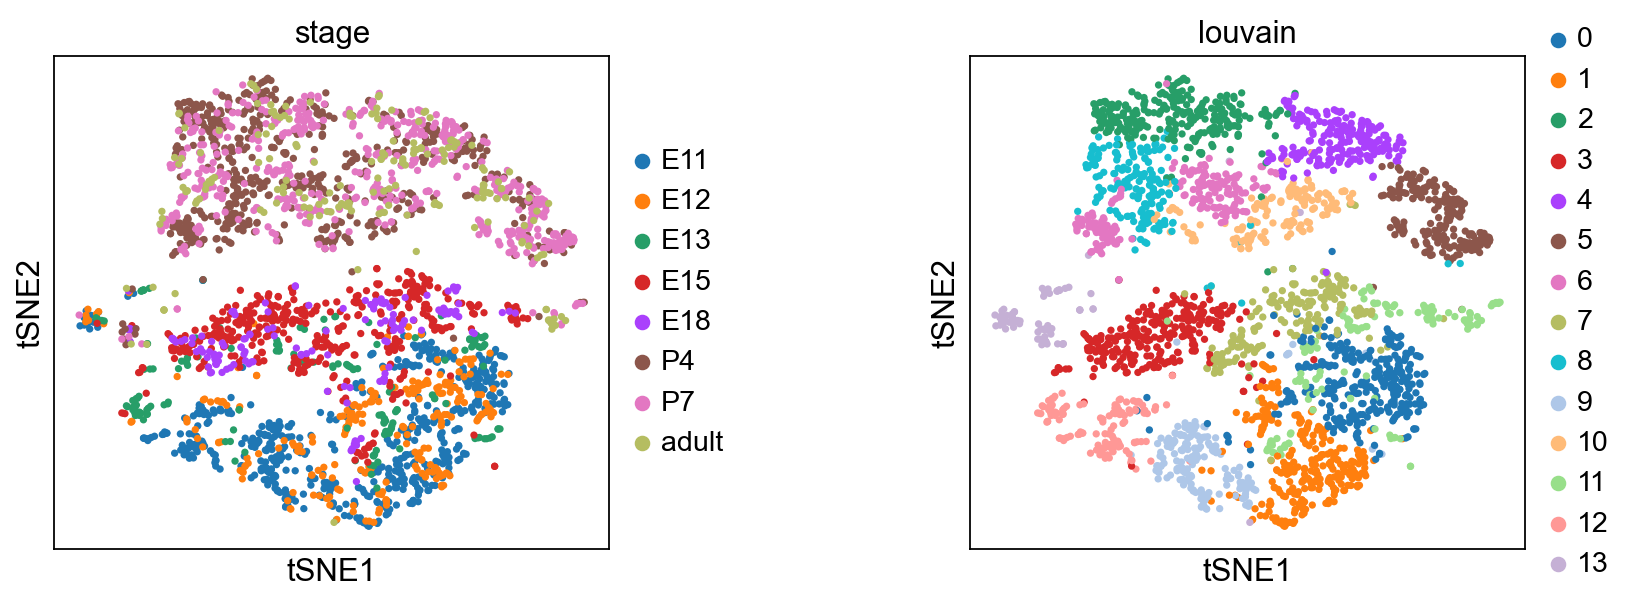

In [26]:
sc.pl.tsne(adata_c, color=['stage', 'louvain'], wspace=0.5, save="_batchcorr_combat.pdf")

Export meta data and t-SNE coordinates for ARI and LISI validation

In [27]:
adata_c.obs.to_csv("../../data/output/embryo_Hb/BatchTest_ComBat_metadata.csv")
umap_c = pd.DataFrame(adata_c.obsm["X_tsne"])
umap_c.index = adata_c.obs.index
umap_c.to_csv("../../data/output/embryo_Hb/BatchTest_ComBat_tsne.csv")

### Plot raw Seurat 

In [28]:
seurat_raw = sc.read_h5ad("../../data/output/embryo_Hb/RawSeurat.h5ad")
seurat_raw

AnnData object with n_obs × n_vars = 2773 × 1010 
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'stage', 'RNA_snn_res.0.8', 'seurat_clusters'
    var: 'mvp.mean', 'mvp.dispersion', 'mvp.dispersion.scaled', 'mvp.variable'
    uns: 'neighbors'
    obsm: 'X_pca', 'X_tsne'
    varm: 'PCs'

In [29]:
seurat_raw.obs["stage"] = adata.obs["stage"]
seurat_raw.obs["seurat_clusters"] = seurat_raw.obs["seurat_clusters"].astype(str)

... storing 'seurat_clusters' as categorical


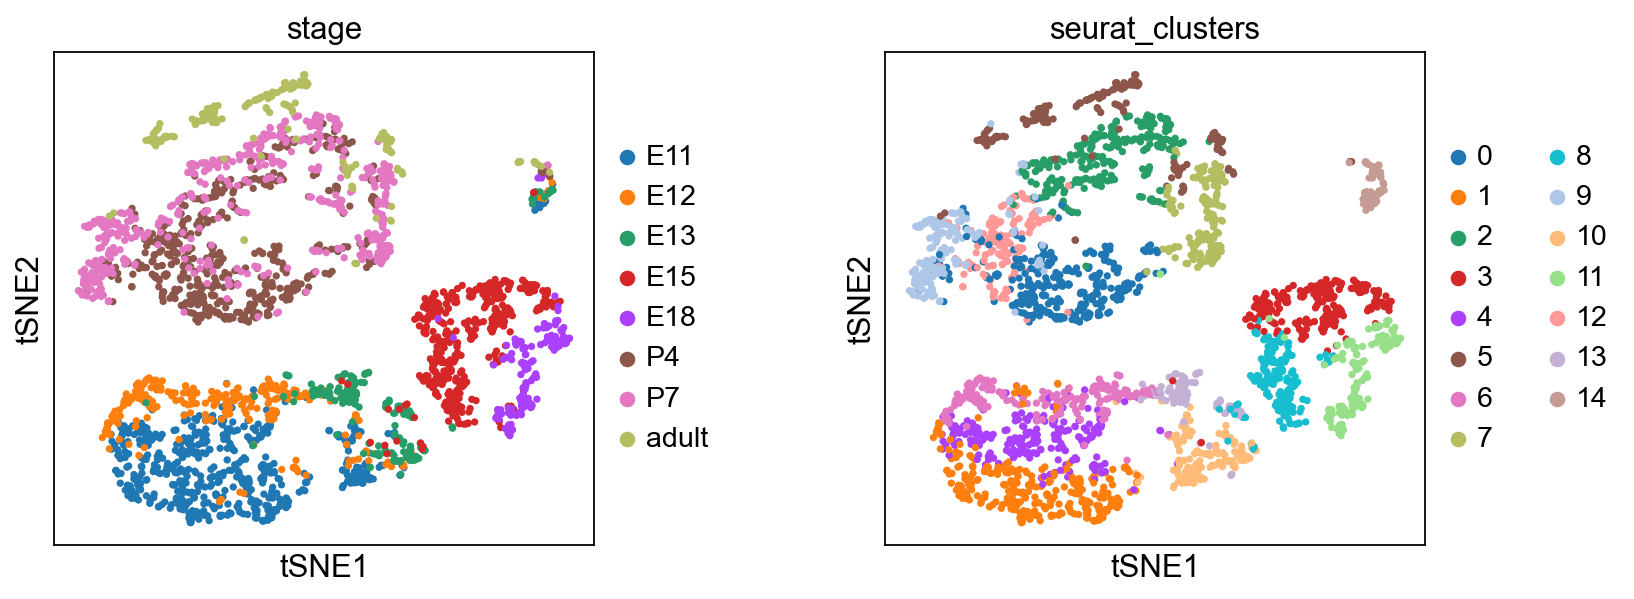

In [30]:
sc.pl.tsne(seurat_raw, color=['stage', 'seurat_clusters'], wspace=0.4, save="_batchcorr_rawseurat.pdf")